In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
p = 1/0.0015
n = 50000000
x = np.random.rand(n)**p
y = np.zeros(n)
for i in range(n):
    y[i] = ( int( np.random.rand() < x[i]) )
x1 = np.random.rand(n)
x2 = x - x1

train = pd.DataFrame({'y': y, 'x': x, 'x1': x1, 'x2': x2})

KeyboardInterrupt: 

In [270]:
bin = np.floor(x*10)
train["bin"] = bin

<AxesSubplot:xlabel='x', ylabel='Probability'>

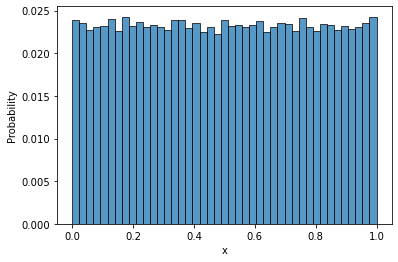

In [271]:
sns.histplot(
    train[y==1], x="x", stat = "probability"
)

In [272]:
x_test = np.random.rand(n)**p
y_test = np.zeros(n)
for i in range(n):
    y_test[i] = ( int( np.random.rand() < x_test[i]) )
x1_test = np.random.rand(n)
x2_test = x_test - x1_test

test = pd.DataFrame({'y': y_test, 'x': x_test, 'x1': x1_test, 'x2': x2_test})

In [273]:
print(np.mean(y))
print(np.mean(x>0.1))


0.00150582
0.00346144


In [274]:
xgbModel = xgb.XGBClassifier( learning_rate = 0.1, max_depth = 5, n_estimators = 200)
xgbModel.fit(train[['x1', 'x2']],train['y'])

C:\Users\iamwl\miniconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [275]:
pred = xgbModel.predict_proba(test[['x1','x2']])[:,1]
pred.mean()

0.0015046893

In [276]:
p_hat = pred

rank = (-p_hat).argsort()

weight_test = np.array(y_test*0.0 + 1.0)

cumSum_prob = np.cumsum(weight_test[rank])

for rate in [.0025,.003,.005,.01]:
    cur_os_vol = weight_test.sum()*rate
    rank_os = rank[ cumSum_prob <= cur_os_vol]
    new_os = np.zeros(len(y_test), dtype = np.bool)
    new_os[rank_os] = 1
    new_os_rate = weight_test[new_os].sum() / float(weight_test.sum())
    new_os_bad_rate = np.array(y_test)[new_os].sum() / float(np.array(y_test).sum())
    new_os_vol = weight_test[new_os].sum()
    new_os_bad_vol = np.array(y_test)[new_os].sum()
    new_os_pred_vol = np.array(p_hat)[new_os].sum()
    cutoff = np.array(p_hat)[new_os].min()

    print(new_os_rate, new_os_bad_rate, new_os_bad_vol, new_os_pred_vol, new_os_vol, cutoff)

C:\Users\iamwl\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


0.0025 0.8119892465927482 60710.0 61549.367 125000.0 0.19983073
0.003 0.8629609319619618 64521.0 65794.19 150000.0 0.141359
0.005 0.9625235732341808 71965.0 71790.266 250000.0 0.007825376
0.01 0.9871066112054784 73803.0 71976.9 500000.0 0.0001769841


In [304]:
sample_index = ((np.random.rand(n) < 0.01) & (y == 0)) | (y == 1)
train_weight = np.array((1-y_test)*100.0 + y_test*1.0)[sample_index]

xgbModel_s = xgb.XGBClassifier( learning_rate = 0.1, max_depth = 5, n_estimators = 400)
xgbModel_s.fit(train[sample_index][['x1', 'x2']], train[sample_index]['y']
#, sample_weight = train_weight
)


[19:40:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [306]:
pred = xgbModel_s.predict_proba(test[['x1','x2']])[:,1]
print(pred.mean())
print((pred/(pred + (1-pred)*100)).mean())

In [305]:
p_hat = pred/(pred + (1-pred)*100)

rank = (-p_hat).argsort()

weight_test = np.array(y_test*0.0 + 1.0)

cumSum_prob = np.cumsum(weight_test[rank])

for rate in [.0025,.003,.005,.01]:
    cur_os_vol = weight_test.sum()*rate
    rank_os = rank[ cumSum_prob <= cur_os_vol]
    new_os = np.zeros(len(y_test), dtype = np.bool)
    new_os[rank_os] = 1
    new_os_rate = weight_test[new_os].sum() / float(weight_test.sum())
    new_os_bad_rate = np.array(y_test)[new_os].sum() / float(np.array(y_test).sum())
    new_os_vol = weight_test[new_os].sum()
    new_os_bad_vol = np.array(y_test)[new_os].sum()
    new_os_pred_vol = np.array(p_hat)[new_os].sum()
    cutoff = np.array(p_hat)[new_os].min()

    print(new_os_rate, new_os_bad_rate, new_os_bad_vol, new_os_pred_vol, new_os_vol, cutoff)

C:\Users\iamwl\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


0.0025 0.8090066473176669 60487.0 2877.9639 125000.0 0.002347455
0.003 0.8582529725681116 64169.0 2923.029 150000.0 0.001379441
0.005 0.9447751013147512 70638.0 2989.6304 250000.0 0.0002972605
0.01 0.9831208955822756 73505.0 3010.902 500000.0 1.4958311e-05


In [300]:
importance = np.minimum(np.ones(n), np.maximum(0.0001*np.ones(n), 750*x) ) 
sample_index = ((np.random.rand(n) < importance) & (y == 0)) | (y == 1)
#sample_index = ((np.random.rand(n) < 0.01) & (y == 0)) | (y == 1)
sample_index.sum()

573692

In [301]:
train_weight = np.array((1-y_test)/importance + y_test*1.0)[sample_index]

xgbModel_s2 = xgb.XGBClassifier( learning_rate = 0.1, max_depth = 5, n_estimators = 400)
xgbModel_s2.fit(train[sample_index][['x1', 'x2']], train[sample_index]['y']
, sample_weight = train_weight
)

[19:37:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [302]:
pred = xgbModel_s2.predict_proba(test[['x1','x2']])[:,1]
print(pred.mean()) 
print((pred/(pred + (1-pred)*100)).mean())

0.0015825423
6.119299e-05


In [303]:
p_hat = pred

rank = (-p_hat).argsort()

weight_test = np.array(y_test*0.0 + 1.0)

cumSum_prob = np.cumsum(weight_test[rank])

for rate in [.0025,.003,.005,.01]:
    cur_os_vol = weight_test.sum()*rate
    rank_os = rank[ cumSum_prob <= cur_os_vol]
    new_os = np.zeros(len(y_test), dtype = np.bool)
    new_os[rank_os] = 1
    new_os_rate = weight_test[new_os].sum() / float(weight_test.sum())
    new_os_bad_rate = np.array(y_test)[new_os].sum() / float(np.array(y_test).sum())
    new_os_vol = weight_test[new_os].sum()
    new_os_bad_vol = np.array(y_test)[new_os].sum()
    new_os_pred_vol = np.array(p_hat)[new_os].sum()
    cutoff = np.array(p_hat)[new_os].min()

    print(new_os_rate, new_os_bad_rate, new_os_bad_vol, new_os_pred_vol, new_os_vol, cutoff)

C:\Users\iamwl\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


0.0025 0.8090066473176669 60487.0 62171.98 125000.0 0.19047862
0.003 0.8582529725681116 64169.0 65984.2 150000.0 0.12136934
0.005 0.9447751013147512 70638.0 72157.97 250000.0 0.028876256
0.01 0.9831208955822756 73505.0 74253.336 500000.0 0.0014936193


Text(0, 0.5, 'sampling rate')

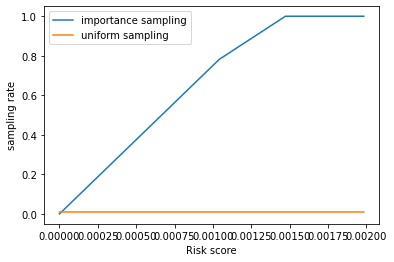

In [288]:
from matplotlib import pyplot as plt

plt.plot(sorted(x[x<0.002][0:10000]),sorted(importance[x<0.002][0:10000]), label = "importance sampling")
plt.plot(sorted(x[x<0.002][0:10000]),np.ones(len(x[x<0.002][0:10000]))*0.01, label = "uniform sampling")
plt.legend()
plt.xlabel("Risk score")
plt.ylabel("sampling rate")